# 선형회귀 데모

**회귀분석: 변수간에 인과관계를 확인 하는 분석

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

## numpy 간단 함수 연산

In [3]:
b = np.arange(12).reshape(3,4)# 0~11 까지 내의 수로 3행 4열 행렬 (재)생성
b

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [4]:
b.sum(axis=0)                # = b.sum(axis=-2)각 열에 있는 값들의 합
b.sum(axis=1)                # = b.sum(axis=-1)각 행에 있는 값들의 합

array([ 6, 22, 38])

In [5]:
b.min(axis=0)                # = b.min(axis=-2) 각 열에 있는 값들 중 최소값
b.min(axis=1)                # = b.min(axis=-1) 각 행에 있는 값들 중 최소값

array([0, 4, 8])

In [6]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [9]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
trn_file = data_dir / 'train.csv'
seed = 42

In [10]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


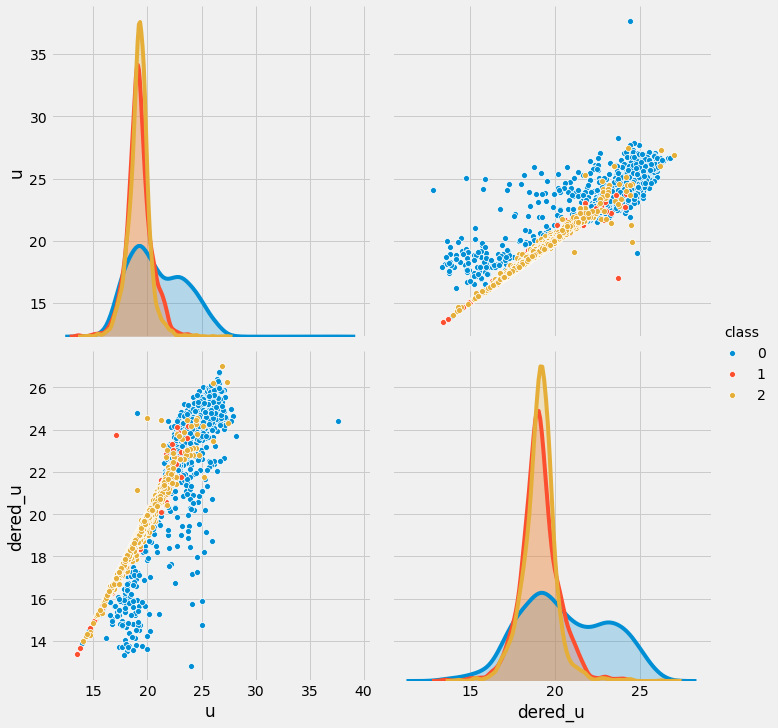

In [11]:
sns.pairplot(trn.sample(n=10000), vars=['u', 'dered_u'], hue='class', size=5)

u 와 dered_u 의 관계가 선형을 나타내기때문에 사용. 표현 아래와 같음

선형 모델 사용을 위해서는 변수들의 독립 종속관계 여부와 상관관계가 선형인지 등 판단이 필요 이전 EDA로 판단O

그러나 실전은 모델을 위한 알고리즘은 대부분 정해져 있음 
>정확도를 위한 모델을 원할 경우 gradient boosting machine(그레디언터 부스팅) or neural network (신경망) 

>모델에 대한 해석이 중요한 경우 Decision tree or Linear regression 사용(단순 알고리즘)

따라서 EDA를 먼저해서 판단하기 보단 확인또는 추가 검증 용도로 사용 (내가 선택한 것이 맞는지 또는 추가 시험_필수)

In [12]:
# class 의 0 값 제외(0의 값 나타내는 파란 점은 선형을 나타내는 노란 점들 범위를 벗어나있음=관련도 낮음) 
X = trn[trn['class'] != 0][['u']].values # u = 독립
y = trn[trn['class'] != 0]['dered_u'].values # dered_u = 종속
print(X.shape, y.shape)

(200004, 1) (200004,)


## RMSE 손실함수 정의

**회귀모델에서 가장 많이 쓰이는 손실함수 계산법

**손실함수(Mean Squared Error): 모델의 에러를 최소화하기 위해 필요한 연산 및 계산

In [13]:
rmse = lambda y, p: np.sqrt(np.mean((y - p) ** 2))
#예측값과 실제값의 오차 제곱에 평균값(mean)에 루트(sqrt)를 씌움
#값이 작을 수록 에러가 적다 = 예측을 더 잘한다 = 성능 좋은 모델
#+손실(에러)를 최소화하는 세타 계수 구하는 방법 = 경사하강법 or 최적세타 계산법
#+실제 루트를 씌운 rmse사용하는 이유(독립변수=평수, 방 개수)
#EX> (예측 집값y-실제 집값p)*독립변수 일때 나오는 에러값의 스케일(단위)과 집값의 스케일(단위) 비슷하게 만들어줌
#=>이는 서로 비교(해석)를 용이케함

In [14]:
def rmse(y,p):
    return np.sqrt(np.mean((y-p)**2))
#위 한줄 식과 같음 (간단함의 차이뿐임+연산 속도 차도 있을 수 있음)

## NumPy를 이용한 선형회귀


 **가장 널리 쓰이는 모델 중 하나
 
 종속(결과)과 독립(원인=feature=variable=column) 변수의 관계를 선형 수식으로 표현
 
 >EX>평수(독립2)와 방의 개수(독립2)가 집의 가격(종속)을 결정한다고 가정
 
         집의 가격 (y(x),결과값 or예측값)=  θ*평수 + θ*방의 개수 

In [15]:
alpha = .001
theta0 = .1
theta1 = .1
epoch = 4 
# 위 3개 초기값으로 4번 정도 반복 계산하기 위한 변수 epoch 
#예측값h(x)= θ0 + θ1*x1 
# θ := θ + alpha (y + h(x)) * x

In [16]:
x = X.flatten()# (200004,1) 독립 u의 2차원을 1차원으로 변환하기 위한 함수 flatten()
print(x.shape)

(200004,)


### 세타 계수를 구하기 위한 경사하강법

In [17]:
#p_i: 한줄 한줄에 대한 예측값
rmses = []
for i in tqdm(range(epoch)):
    for x_i, y_i in zip(x, y):
        p_i =  theta0 + theta1 * x_i
        theta0 = theta0 + alpha * (y_i - p_i)
        theta1 = theta1 + alpha * (y_i - p_i) * x_i
    rmses.append(rmse(y, theta0 + theta1 * x))

In [18]:
theta1, theta0              #에러값 세타 변경된것을 볼 수 있음

(0.9362306162023849, 1.1088813148478316)

In [19]:
rmses

[0.25618215910731906,
 0.25492967552380746,
 0.25461791287963526,
 0.25454708923095914]

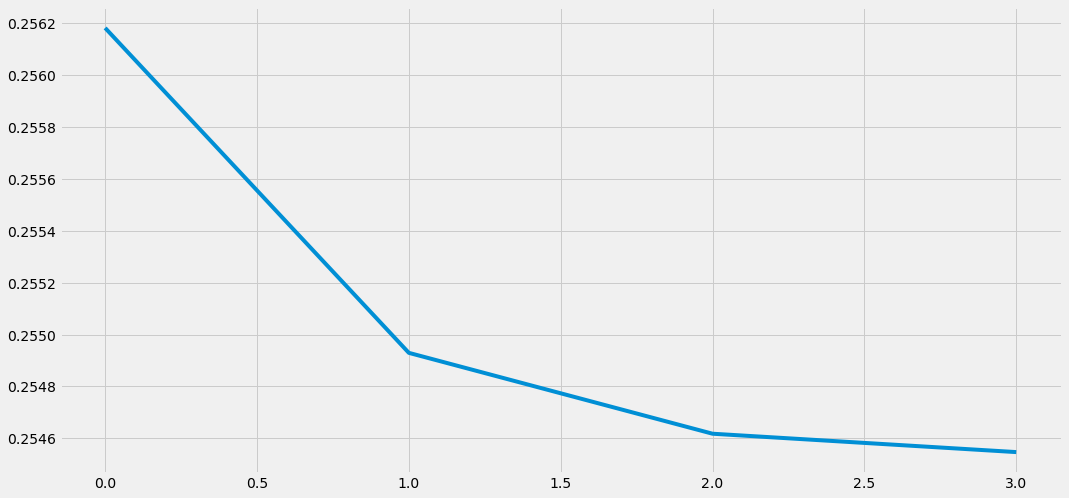

In [20]:
plt.plot(rmses)              #위의 값 보면 비슷해 보이지만 아래 그래프로 그림 에러가 개선된 것을 볼 수 있음

Text(0, 0.5, 'dered_u')

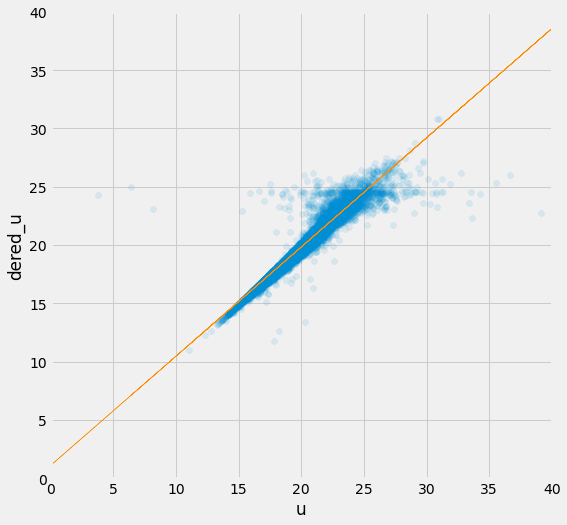

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=.1)
plt.plot(X, theta0 + theta1 * x, color='darkorange', linewidth=.5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

In [22]:
#파:실제값 주:예측값
#주황 선이 파란 점들 범위에 속한 것을 볼 수 있음 = 다소 정확!!

## scikit-learn을 이용한 선형회귀 
#### **실제 위처럼 계산 하나하나 돌릴 필요X ->sklearn.linear_model에 계산이 포함 + 자동 연산 가능

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)                 #학습 함수
p = lr.predict(X)            #예측값 초기화

In [24]:
rmse(y, p)

0.2522450693360897

In [25]:
lr.coef_, lr.intercept_       #theta0 theta1 위의 값 비슷하게 나온것을 확인 가능

(array([0.9320425]), 1.1556424178625164)

Text(0, 0.5, 'dered_u')

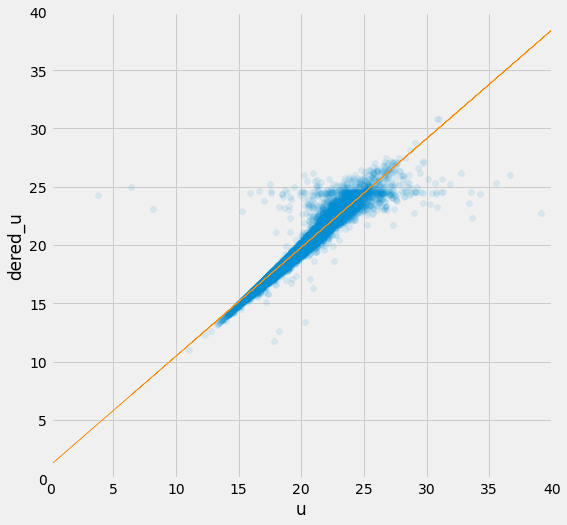

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=.1)
plt.plot(X, p, color='darkorange', linewidth=.5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

## scikit-learn을 이용한 로지스틱 회귀
#### **종속 실수 또는 범주(암 여부 or 남녀) 이냐에 따라 다름(로지스틱 그래프는 y가  x증가에 따라 0과1에서 점점 증가)

목표는 class 예측
>X = trn[trn['class'] != 0].drop('class', axis=1) --> class 를 제외한 모든 컬럼 변수를 독립변수로 사용

>y = trn[trn['class'] != 0]['class'].values - 1 --> class 를 종속변수 y로 사용

실제 class는 다중 클래스 -> 다중 분류기 사용 / linear or logistic 회귀의 경우->이진분류기 사용

그러나 여서는 로지스틱 예를 위해 다중 클래스를 이진분류기 사용에 맞게 0,1,2 중 0 제거

In [30]:
X = trn[trn['class'] != 0].drop('class', axis=1)#class 를 제외한 모든 컬럼 변수를 독립변수로 사용
y = trn[trn['class'] != 0]['class'].values - 1 #class 를 종속변수 y로 사용

In [31]:
np.unique(y)

array([0, 1], dtype=int64)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

lr = LogisticRegression()
lr.fit(X,  y)                        #모델 학습
p = lr.predict_proba(X)[:, 1]        #예측값 초기화
#predict는 레이블 클래스를 리턴
#그러나 각 값의 예측 확률 추출을 위해  predix_proba 사용

In [33]:
lr.coef_, lr.intercept_#theta0 theta1 들

(array([[ 0.96699189,  0.16504999, -1.82734962,  0.49227808, -0.4796174 ,
         -1.3623878 ,  2.1781983 , -0.05597392, -1.39840438,  0.41024711,
         -0.66573477,  0.03483603, -0.05137585, -0.09415588, -0.0964362 ,
         -0.09199701, -0.09306227, -0.09528153]]),
 array([0.21433421]))

In [34]:
log_loss(y, p)                        #로그 손실함수

0.36589855741992827

In [43]:
#!pip install kaggle

In [45]:
!pip install -U kaggler

  Using cached Kaggler-0.8.12.tar.gz (887 kB)

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\USER\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\USER\\AppData\\Local\\Temp\\pip-install-cj3syevi\\kaggler\\setup.py'"'"'; __file__='"'"'C:\\Users\\USER\\AppData\\Local\\Temp\\pip-install-cj3syevi\\kaggler\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\USER\AppData\Local\Temp\pip-wheel-dixh5ym7'
       cwd: C:\Users\USER\AppData\Local\Temp\pip-install-cj3syevi\kaggler\
  Complete output (41 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\kaggler
  copying kaggler\const.py -> build\lib.win-amd64-3.8\kaggler
  copying kaggler\data_io.py -> build\lib.win-amd64-3.8\kaggler
  copying kaggler\__init__.py -> build\lib.win

  copying kaggler\ensemble\__init__.py -> build\lib.win-amd64-3.8\kaggler\ensemble
  creating build\lib.win-amd64-3.8\kaggler\model
  copying kaggler\model\automl.py -> build\lib.win-amd64-3.8\kaggler\model
  copying kaggler\model\nn.py -> build\lib.win-amd64-3.8\kaggler\model
  copying kaggler\model\__init__.py -> build\lib.win-amd64-3.8\kaggler\model
  creating build\lib.win-amd64-3.8\kaggler\metrics
  copying kaggler\metrics\classification.py -> build\lib.win-amd64-3.8\kaggler\metrics
  copying kaggler\metrics\regression.py -> build\lib.win-amd64-3.8\kaggler\metrics
  copying kaggler\metrics\__init__.py -> build\lib.win-amd64-3.8\kaggler\metrics
  creating build\lib.win-amd64-3.8\kaggler\online_model
  copying kaggler\online_model\classification_tree.py -> build\lib.win-amd64-3.8\kaggler\online_model
  copying kaggler\online_model\__init__.py -> build\lib.win-amd64-3.8\kaggler\online_model
  creating build\lib.win-amd64-3.8\kaggler\preprocessing
  copying kaggler\preprocessing\categ


  Running setup.py clean for kaggler
Failed to build kaggler
    Running setup.py install for kaggler: started
    Running setup.py install for kaggler: finished with status 'error'


In [46]:
from kaggler.metrics import plot_roc_curve, plot_pr_curve

ModuleNotFoundError: No module named 'kaggler'

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plot_roc_curve(y, p);
plt.title('ROC Curve')
plt.subplot(1, 2, 2)
plot_pr_curve(y, p);
plt.title('Precision-Recall Curve')